In [83]:
!pip -q install medmnist

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F


import medmnist
from medmnist import INFO

In [84]:
data_flag = 'pneumoniamnist'
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print("task:", task)
print("n_channels:", n_channels)
print("n_classes:", n_classes)
print("labels:", info['label'])


task: binary-class
n_channels: 1
n_classes: 2
labels: {'0': 'normal', '1': 'pneumonia'}


In [85]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # grayscale
])

In [86]:
DataClass = getattr(medmnist, info['python_class'])

train_ds = DataClass(split='train', transform=transform, download=True)
val_ds   = DataClass(split='val',   transform=transform, download=True)
test_ds  = DataClass(split='test',  transform=transform, download=True)

print(len(train_ds), len(val_ds), len(test_ds))

4708 524 624


In [87]:
x0, y0 = train_ds[0]
print("x shape:", x0.shape, "dtype:", x0.dtype)   # expect [1, 28, 28]
print("y:", y0, "y shape:", np.array(y0).shape)  # often [1]


x shape: torch.Size([1, 28, 28]) dtype: torch.float32
y: [1] y shape: (1,)


In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [88]:
def label_counts(ds):
    ys = np.array([ds[i][1].item() for i in range(len(ds))])  # .item() extracts scalar safely
    unique, counts = np.unique(ys, return_counts=True)
    return {int(k): int(v) for k, v in zip(unique, counts)}


print("train counts:", label_counts(train_ds))
print("val counts:", label_counts(val_ds))
print("test counts:", label_counts(test_ds))


train counts: {0: 1214, 1: 3494}
val counts: {0: 135, 1: 389}
test counts: {0: 234, 1: 390}


/tmp/ipython-input-26763894.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"y={int(y)}")


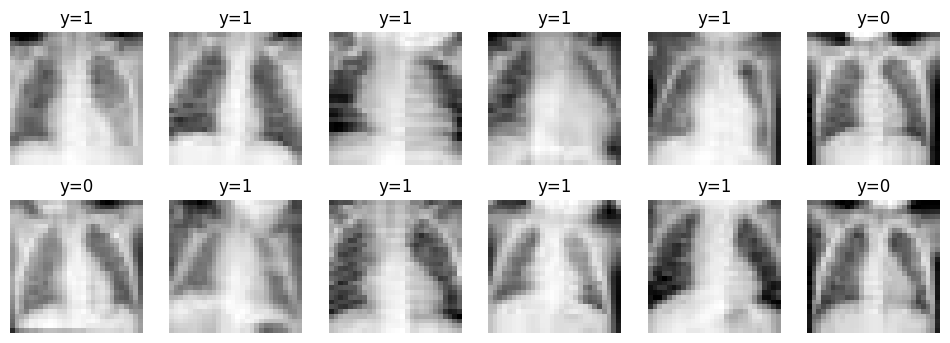

In [89]:
fig, axes = plt.subplots(2, 6, figsize=(12, 4))
for ax in axes.ravel():
    idx = np.random.randint(len(train_ds))
    x, y = train_ds[idx]
    img = x.squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"y={int(y)}")
    ax.axis('off')
plt.show()

In [90]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory = (device.type == "cuda")
)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory = (device.type == "cuda")
)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory = (device.type == "cuda")
)


In [91]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # [B,16,28,28]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B,16,14,14]

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # [B,32,14,14]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B,32,7,7]
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                                # [B,32*7*7]
            nn.Linear(32*7*7, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)                             # logits (NOT probability)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [93]:
def compute_metrics_from_logits(logits, y_true, threshold=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).long()

    y_true = y_true.long()

    tp = ((preds == 1) & (y_true == 1)).sum().item()
    tn = ((preds == 0) & (y_true == 0)).sum().item()
    fp = ((preds == 1) & (y_true == 0)).sum().item()
    fn = ((preds == 0) & (y_true == 1)).sum().item()

    accuracy = (tp + tn) / max(tp + tn + fp + fn, 1)
    precision = tp / max(tp + fp, 1)
    recall = tp / max(tp + fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-12)

    return {
        "acc": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": tp, "tn": tn, "fp": fp, "fn": fn
    }


In [94]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    criterion = nn.BCEWithLogitsLoss(reduction='none')


    for x, y in loader:
        x = x.to(device)
        y = torch.as_tensor(y, dtype=torch.float32, device=device).view(-1, 1)


        logits = model(x)
        loss_vec = criterion(logits, y)                 # [B,1]
        weights = torch.where(y == 1, w1, w0)          # [B,1]
        loss = (loss_vec * weights).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    return total_loss / len(loader.dataset)


In [95]:
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0

    all_logits = []
    all_y = []


    for x, y in loader:
        x = x.to(device)
        y = torch.tensor(y).float().to(device).view(-1, 1)

        logits = model(x)
        loss_vec = criterion(logits, y)                 # [B,1]
        weights = torch.where(y == 1, w1, w0)          # [B,1]
        loss = (loss_vec * weights).mean()


        total_loss += loss.item() * x.size(0)
        all_logits.append(logits.cpu())
        all_y.append(y.cpu())

    all_logits = torch.cat(all_logits, dim=0)
    all_y      = torch.cat(all_y, dim=0)

    all_probs = torch.sigmoid(all_logits)   # now it works
    all_probs = F.sigmoid(all_logits)


    metrics = compute_metrics_from_logits(all_logits, all_y)
    metrics["loss"] = total_loss / len(loader.dataset)
    return metrics


In [96]:
@torch.no_grad()
def get_probs_and_labels(model, loader):
    model.eval()
    probs_list, y_list = [], []

    for x, y in loader:
        x = x.to(device)
        y = torch.as_tensor(y, dtype=torch.float32, device=device).view(-1, 1)

        logits = model(x)
        probs = torch.sigmoid(logits)

        probs_list.append(probs.cpu())
        y_list.append(y.cpu())

    return torch.cat(probs_list, dim=0), torch.cat(y_list, dim=0)

In [97]:
val_probs, val_y = get_probs_and_labels(model, val_loader)

In [98]:
epochs = 5

for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_metrics = evaluate(model, val_loader, criterion)

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} | "
        f"val_loss={val_metrics['loss']:.4f} | "
        f"acc={val_metrics['acc']:.3f} | "
        f"prec={val_metrics['precision']:.3f} | "
        f"rec={val_metrics['recall']:.3f} | "
        f"f1={val_metrics['f1']:.3f} | "
        f"TP={val_metrics['tp']} FP={val_metrics['fp']} FN={val_metrics['fn']} TN={val_metrics['tn']}"
    )


/tmp/ipython-input-1439383469.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float().to(device).view(-1, 1)


Epoch 01 | train_loss=0.4826 | val_loss=0.3039 | acc=0.870 | prec=0.985 | rec=0.838 | f1=0.906 | TP=326 FP=5 FN=63 TN=130
Epoch 02 | train_loss=0.2032 | val_loss=0.2119 | acc=0.908 | prec=0.980 | rec=0.895 | f1=0.935 | TP=348 FP=7 FN=41 TN=128
Epoch 03 | train_loss=0.1681 | val_loss=0.1325 | acc=0.954 | prec=0.964 | rec=0.974 | f1=0.969 | TP=379 FP=14 FN=10 TN=121
Epoch 04 | train_loss=0.1502 | val_loss=0.1444 | acc=0.941 | prec=0.979 | rec=0.941 | f1=0.959 | TP=366 FP=8 FN=23 TN=127
Epoch 05 | train_loss=0.1404 | val_loss=0.1352 | acc=0.948 | prec=0.974 | rec=0.956 | f1=0.965 | TP=372 FP=10 FN=17 TN=125


In [99]:
train_counts = label_counts(train_ds)
c0, c1 = train_counts[0], train_counts[1]
total = c0 + c1

w0 = total / (2 * c0)
w1 = total / (2 * c1)

print("w0 (normal):", w0, "w1 (pneumonia):", w1)


w0 (normal): 1.9390444810543657 w1 (pneumonia): 0.6737263880938752


In [100]:
def metrics_at_threshold(probs, y_true, thr):
    preds = (probs >= thr).long()
    y_true = y_true.long()

    tp = ((preds == 1) & (y_true == 1)).sum().item()
    tn = ((preds == 0) & (y_true == 0)).sum().item()
    fp = ((preds == 1) & (y_true == 0)).sum().item()
    fn = ((preds == 0) & (y_true == 1)).sum().item()

    precision = tp / max(tp + fp, 1)
    recall    = tp / max(tp + fn, 1)
    f1        = 2 * precision * recall / max(precision + recall, 1e-12)
    acc       = (tp + tn) / max(tp + tn + fp + fn, 1)

    return acc, precision, recall, f1, fp, fn

thresholds = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70]
print("thr |  acc  prec  rec   f1   | FP  FN")
print("----------------------------------------")
for thr in thresholds:
    acc, prec, rec, f1, fp, fn = metrics_at_threshold(val_probs, val_y, thr)
    print(f"{thr:0.2f} | {acc:0.3f} {prec:0.3f} {rec:0.3f} {f1:0.3f} | {fp:3d} {fn:3d}")


thr |  acc  prec  rec   f1   | FP  FN
----------------------------------------
0.10 | 0.742 0.742 1.000 0.852 | 135   0
0.20 | 0.742 0.742 1.000 0.852 | 135   0
0.30 | 0.742 0.742 1.000 0.852 | 135   0
0.40 | 0.742 0.742 1.000 0.852 | 135   0
0.50 | 0.258 0.000 0.000 0.000 |   0 389
0.60 | 0.258 0.000 0.000 0.000 |   0 389
0.70 | 0.258 0.000 0.000 0.000 |   0 389


In [102]:
val_probs, val_y = get_probs_and_labels(model, val_loader)
print("val_probs min/max:", val_probs.min().item(), val_probs.max().item())
print("fraction >= 0.5:", (val_probs >= 0.5).float().mean().item())

val_probs min/max: 0.00045944537851028144 0.9999741315841675
fraction >= 0.5: 0.7290076613426208


In [103]:
acc, prec, rec, f1, fp, fn = metrics_at_threshold(val_probs, val_y, 0.50)
print(acc, prec, rec, f1, fp, fn)


0.9484732824427481 0.9738219895287958 0.9562982005141388 0.9649805447470817 10 17


In [104]:
thresholds = [i/100 for i in range(5, 61, 5)]  # 0.05, 0.10, ..., 0.60

print("thr |  acc   prec  rec   f1   | FP  FN")
print("------------------------------------------")
for thr in thresholds:
    acc, prec, rec, f1, fp, fn = metrics_at_threshold(val_probs, val_y, thr)
    print(f"{thr:0.2f} | {acc:0.3f} {prec:0.3f} {rec:0.3f} {f1:0.3f} | {fp:3d} {fn:3d}")


thr |  acc   prec  rec   f1   | FP  FN
------------------------------------------
0.05 | 0.935 0.924 0.995 0.958 |  32   2
0.10 | 0.954 0.948 0.992 0.970 |  21   3
0.15 | 0.956 0.958 0.985 0.971 |  17   6
0.20 | 0.958 0.962 0.982 0.972 |  15   7
0.25 | 0.958 0.965 0.979 0.972 |  14   8
0.30 | 0.956 0.967 0.974 0.971 |  13  10
0.35 | 0.952 0.967 0.969 0.968 |  13  12
0.40 | 0.950 0.969 0.964 0.966 |  12  14
0.45 | 0.952 0.972 0.964 0.968 |  11  14
0.50 | 0.948 0.974 0.956 0.965 |  10  17
0.55 | 0.948 0.981 0.949 0.965 |   7  20
0.60 | 0.941 0.986 0.933 0.959 |   5  26


In [106]:
best_thr = 0.10
test_probs, test_y = get_probs_and_labels(model, test_loader)
acc, prec, rec, f1, fp, fn = metrics_at_threshold(test_probs, test_y, best_thr)

print("TEST @ thr", best_thr)
print("acc", acc, "prec", prec, "rec", rec, "f1", f1, "FP", fp, "FN", fn)


TEST @ thr 0.1
acc 0.8044871794871795 prec 0.7648221343873518 rec 0.9923076923076923 f1 0.8638392857142857 FP 119 FN 3


In [107]:
best_thr = 0.10

# get test probabilities and labels (already done, but safe to re-run)
test_probs, test_y = get_probs_and_labels(model, test_loader)

preds = (test_probs >= best_thr).long()
y_true = test_y.long()

# indices
fp_idx = ((preds == 1) & (y_true == 0)).nonzero(as_tuple=True)[0]
fn_idx = ((preds == 0) & (y_true == 1)).nonzero(as_tuple=True)[0]

print("FP count:", len(fp_idx))
print("FN count:", len(fn_idx))


FP count: 119
FN count: 3


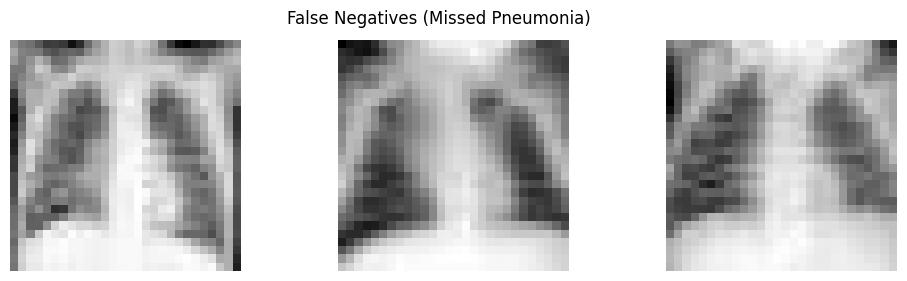

In [108]:
def show_images(indices, title, max_images=6):
    fig, axes = plt.subplots(1, min(len(indices), max_images), figsize=(12, 3))
    fig.suptitle(title)

    for ax, idx in zip(axes, indices[:max_images]):
        x, y = test_ds[idx.item()]
        ax.imshow(x.squeeze(), cmap="gray")
        ax.axis("off")

    plt.show()

show_images(fn_idx, "False Negatives (Missed Pneumonia)")


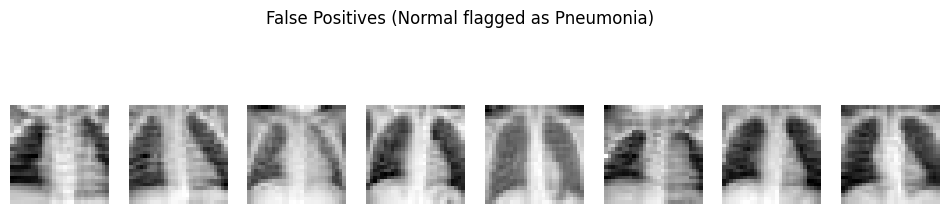

In [109]:
show_images(fp_idx, "False Positives (Normal flagged as Pneumonia)", max_images=8)
